In [34]:
import numpy             as np
import matplotlib.pyplot as plt

from matplotlib          import rcParams, rc
# Change the matplotlib default parameters
# rcParams.update({'font.size':   12})
rcParams.update({'figure.dpi': 120})
# rc('font', family='serif')
# rc('text', usetex=True)

from astropy import units as units


from src.rates          import initialise_abs, calculate_rates, read_specs_file
from src.input          import getcst, density

from scipy.integrate    import solve_ivp
from astropy            import constants

rate = 16
if rate == 13:
    from src.ode.dcodes     import ODE
if rate == 16:
    from src.ode.acodes     import ODE

specs, parnt, consv = read_specs_file('C', rate)

specs_dict = dict()
for i in range(len(specs)):
    specs_dict[specs[i]] = i

In [179]:
## input values physics
def setinput(Mdot, vexp, r, T, δ, Av, chemtype):
    '''
    Set input values of the model.

    INPUT:
        - ρ  = density       [g/cm^3]
            via mass-loss rate (Mdot [Msol/yr]) & expansion velocity (vexp [km/s])
        - T  = temperature   [K]
        - δ  = outwards dilution of radiation field     == RAD
        - Av = outward dus extinction
        - chemtype = type of chemistry: 'C' or 'O'
    '''

    ## input physics
    ρ = density(Mdot, vexp, r)

    print('-----------------------')
    print('| Input:')
    print('|    ')
    print('|    ρ  =','{:.2E}'.format(ρ))
    print('|    T  =',T)
    print('|    δ  =',δ)
    print('|    Av =',Av)
    print('|    Chem type =', chemtype)
    print('|    Rate      =', rate)
    print('-----------------------')
    print('')

    return ρ, T, δ, Av, chemtype

def solve(ρ, T, δ, Av, chemtype, Δt):

    ## calculate H accretion on dust
    Haccr = stckH *np.pi*(rGr**2.0)*ρ*nGr*(8.0*kB*T/(np.pi*mH))**0.5

    ## set initial conditions
    n, nconsv_tot, specs = initialise_abs(chemtype, rate)     # nconsv_tot = TOTAL in fortran code
    timesteps = 1

    ndot        = np.zeros(len(n))
    nconsv      = np.zeros(len(nconsv_tot))
    t           = np.zeros(timesteps)

    k = calculate_rates(T, δ, Av, rate)

    Δt = Δt*yr_to_sec  ## in sec


    print(' >> Solving ODE with Δt',Δt,'...')
    ## solve ODE
    solution = solve_ivp(
        fun          = ODE,
        t_span       = [0.0, Δt],
        y0           = n,
        method       = 'BDF',   ## zoals DVODE
        args         = (ndot, nconsv, nconsv_tot,k, ρ, Haccr),
        dense_output = False    ## if True: returns interpolation function
        )

    assert solution['status'] == 0

    ys = solution['y']
    ts = solution['t']

    print(solution['message'])

    return ts, ys

def plot(ts, ys, lowlim = 10e-400, molecs = None):
    fig = plt.figure(figsize=(8,6))

    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    axs = [ax1,ax2]

    if molecs == None:
        for i in range(ys.shape[0]):
            ax1.plot(ts, ys[i], alpha = 0.5, lw = 0.5, marker='x', ms = 2)
            ax2.plot(ts, -ys[i], alpha = 0.8, lw = 0.5)

    if molecs != None:
        for imol in molecs:
            ax1.plot(ts, ys[imol], alpha = 0.5, lw = 0.5, marker='x', ms = 2, label = specs[imol])
            ax2.plot(ts, -ys[imol], alpha = 0.8, lw = 0.5)

    for ax in axs:
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_ylim((lowlim, 1.0e+0))

        # ax.set_xlim(0, 1.e-3)

    ax.set_xlabel('time [s]')
    ax1.set_ylabel('abundance')
    ax1.set(xticklabels=[])
    ax2.set_ylabel('negative abundance')
    ax2.invert_yaxis()

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.05)
    ax1.legend(fontsize = 7)
    plt.show()

    return

def search_negs(ys, elwise = False, el = None):
    idx = list()

    if elwise == False:
        for ispec in range(ys.shape[0]):
            if np.any(ys[ispec] < 0):
                idx.append(ispec)

    if elwise == True:
        # print(ys.shape)
        for ispec in range(ys.shape[0]):
            if np.any(ys[ispec][el] < 0):
                # print(i,el)
                idx.append(ispec)


    molecs = list()

    for i in idx:
        molecs.append(specs[i])

    return idx, molecs

## search for zeros

# [44, 45, 48, 49, 311, 315]
# ['Na', 'Na+', 'Mg', 'Mg+', 'Fe+', 'Fe']



def search_zeros(ys, elwise = False, el = None):
    idx = list()

    if elwise == False:
        for ispec in range(1,ys.shape[0]):
            if np.any(ys[ispec] == 0):
                idx.append(ispec)

    if elwise == True:
        # print(ys.shape)
        for ispec in range(1,ys.shape[0]):
            if np.any(ys[ispec][el] == 0):
                idx.append(ispec)


    molecs = list()

    for i in idx:
        molecs.append(specs[i])

    return idx, molecs

### Test simulations

In [160]:
## constants
kB, mH, rGr, nGr, stckH, AUV_AV = getcst()
yr_to_sec = units.year.to('s')         ## year in seconds

In [161]:
Mdots = np.array([1.e-8, 1.e-7, 1.e-6, 1.e-5])
vexps = np.array([5.,10.,15.,20.])
Ts = np.array([2500])
chemtype = np.array(['C', 'O'])

In [177]:
ts_O = dict()
ys_O = dict()

for i in range(len(Mdots)):
    ρ, T, δ, Av, chemtype= setinput(Mdots[i],vexps[i], 1.e15, Ts[0], 1., 1., 'O')
    ts_O[i], ys_O[i] = solve(ρ, T, δ, Av, chemtype, 1.e1)


-----------------------
| Input:
|    
|    ρ  = 2.25E+04
|    T  = 2500
|    δ  = 1.0
|    Av = 1.0
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving ODE with Δt 315576000.0 ...
The solver successfully reached the end of the integration interval.
-----------------------
| Input:
|    
|    ρ  = 1.13E+05
|    T  = 2500
|    δ  = 1.0
|    Av = 1.0
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving ODE with Δt 315576000.0 ...
The solver successfully reached the end of the integration interval.
-----------------------
| Input:
|    
|    ρ  = 7.51E+05
|    T  = 2500
|    δ  = 1.0
|    Av = 1.0
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving ODE with Δt 315576000.0 ...
The solver successfully reached the end of the integration interval.
-----------------------
| Input:
|    
|    ρ  = 5.63E+06
|    T  = 2500
|    δ  = 1.0
|    Av = 1.0
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving O

In [178]:
ts_C = dict()
ys_C = dict()

for i in range(len(Mdots)):
    ρ, T, δ, Av, chemtype= setinput(Mdots[i],vexps[i], 1.e15, Ts[0], 1., 1., 'C')
    ts_C[i], ys_C[i] = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 2.25E+04
|    T  = 2500
|    δ  = 1.0
|    Av = 1.0
|    Chem type = C
|    Rate      = 16
-----------------------

 >> Solving ODE with Δt 315576000.0 ...
The solver successfully reached the end of the integration interval.
-----------------------
| Input:
|    
|    ρ  = 1.13E+05
|    T  = 2500
|    δ  = 1.0
|    Av = 1.0
|    Chem type = C
|    Rate      = 16
-----------------------

 >> Solving ODE with Δt 315576000.0 ...
The solver successfully reached the end of the integration interval.
-----------------------
| Input:
|    
|    ρ  = 7.51E+05
|    T  = 2500
|    δ  = 1.0
|    Av = 1.0
|    Chem type = C
|    Rate      = 16
-----------------------

 >> Solving ODE with Δt 315576000.0 ...
The solver successfully reached the end of the integration interval.
-----------------------
| Input:
|    
|    ρ  = 5.63E+06
|    T  = 2500
|    δ  = 1.0
|    Av = 1.0
|    Chem type = C
|    Rate      = 16
-----------------------

 >> Solving O

/tmp/ipykernel_112739/2891020589.py:88: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


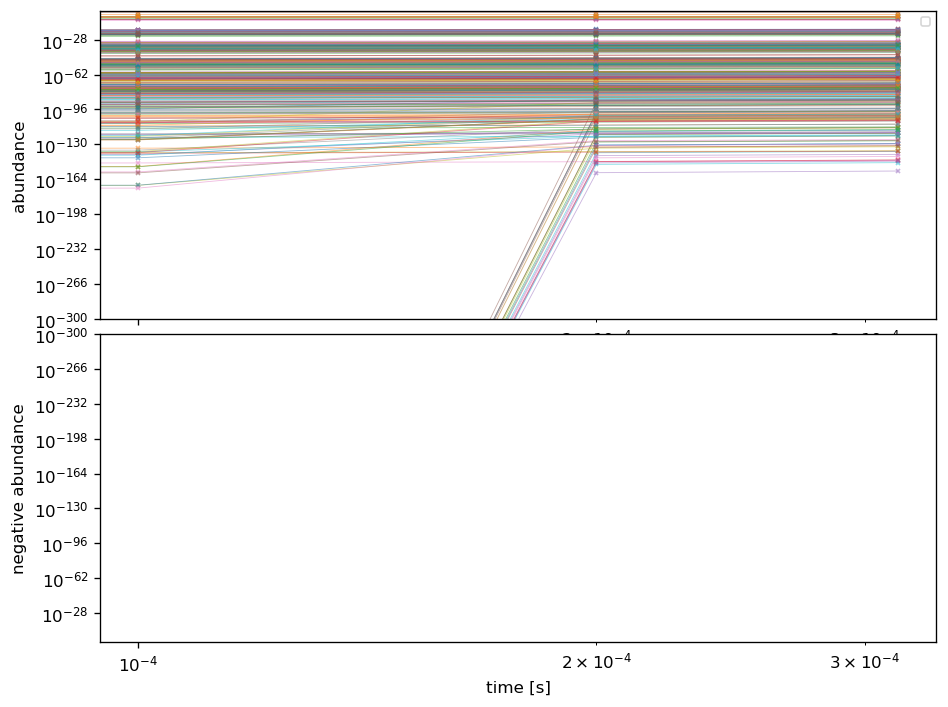

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


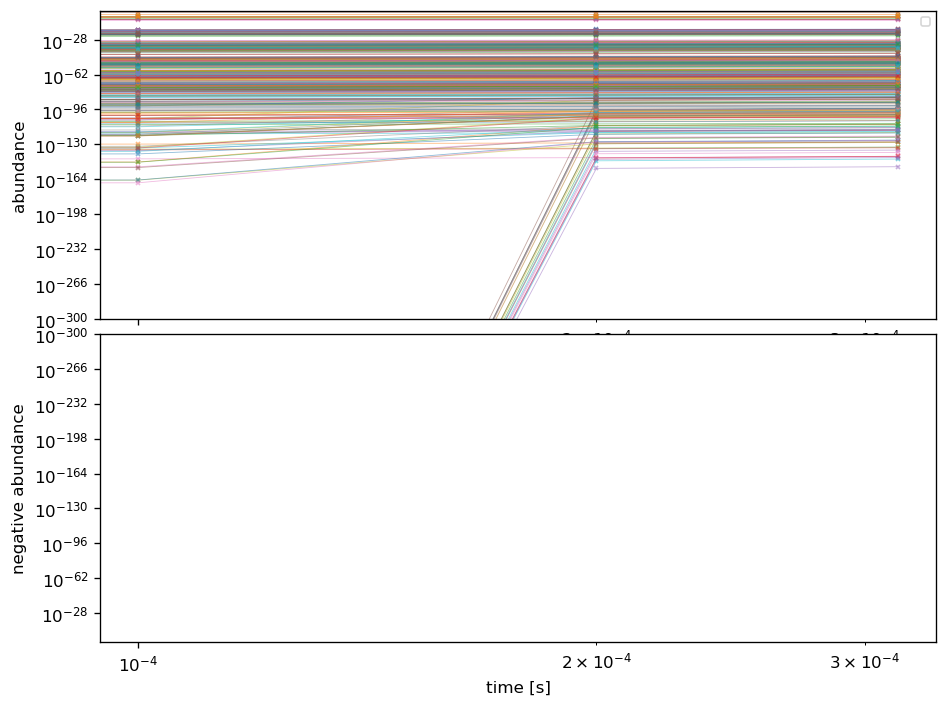

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


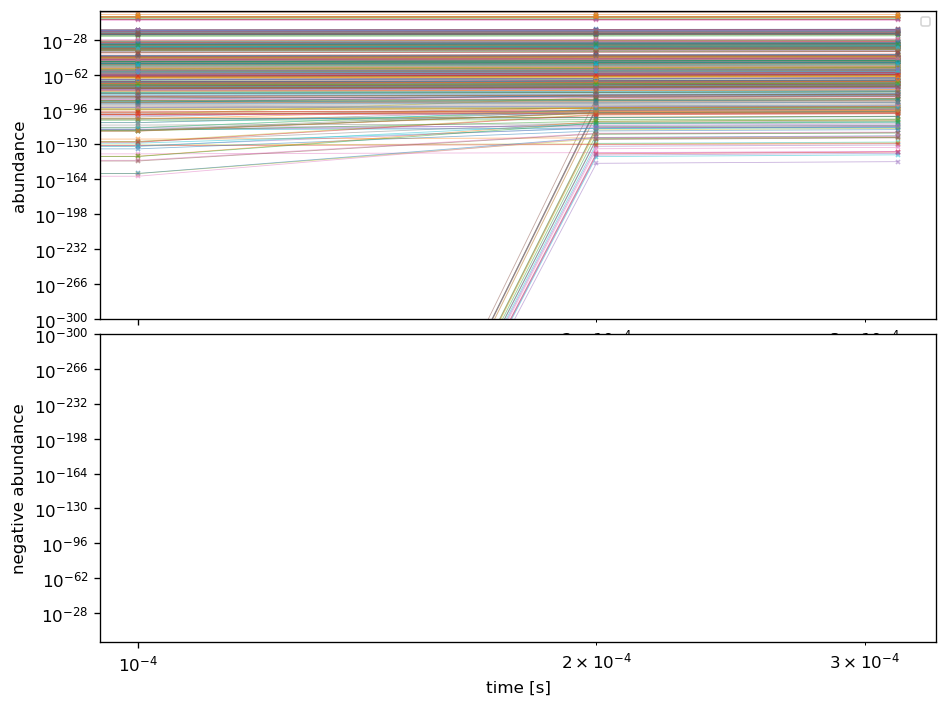

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


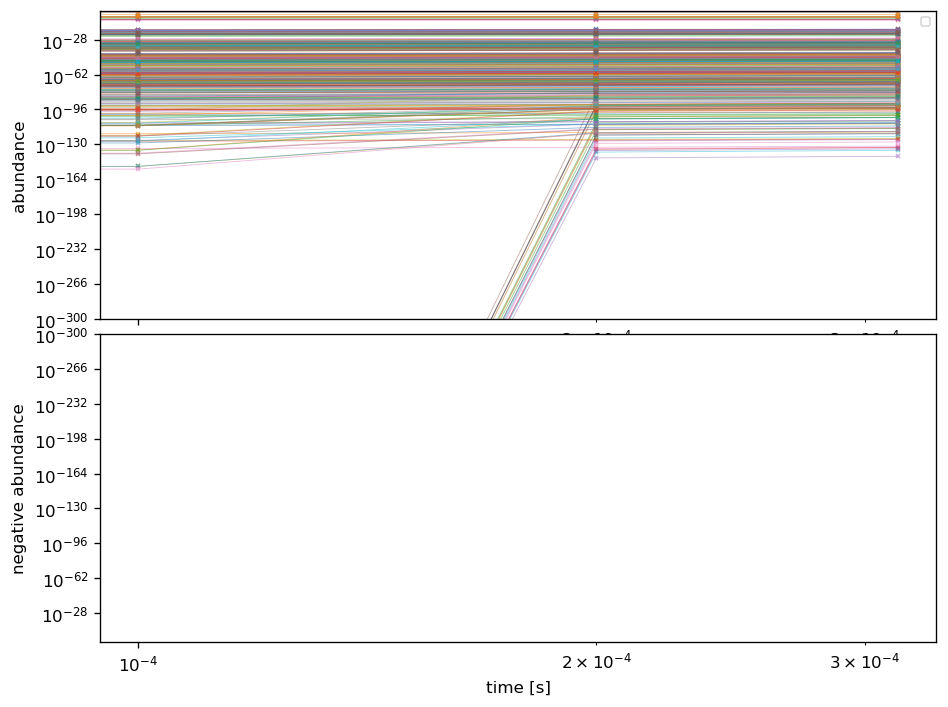

In [175]:
# molecs = [180, 194, 182,27,9,4, 6, 0, 27]     ## CNO
# molecs = [6,182,4,173,194]                      ## HONC+
# molecs = [17, 336]                            ## C5N+

molecs = None
for sim in ys_O:
    plot(ts_O[sim],(ys_O[sim]), lowlim=1.e-300, molecs = molecs)

In [176]:
y = ys_O[0]

# idx_zero, specs_zero = search_zeros(y)
# print('Negative values overal:')
# print('#:',len(idx_zero))
# print(idx_zero)
# print(specs_zero)

# print('')

el = 1
for el in range(1,y.shape[1]-1):
    idx_zero, specs_zero = search_zeros(y, elwise = True, el=el)
    length = len(idx_zero)
    if el == 1:
        print('Zero values on position', 1)
        print('#:',length)
        for i in range(length):
            print(idx_zero[i], specs_zero[i])
    elif length != 0:
        print('\nZero values on position',el)
        print('#:',length)
        print(idx_zero)
        print(specs_zero)

Zero values on position 1
#: 27
44 Na
45 Na+
48 Mg
49 Mg+
109 SiH4+
173 CNO
180 HCNO+
182 HONC
194 HONC+
196 HCNOH+
208 H2CNO+
224 H2SiO
235 H2SiO+
252 H3SiO+
276 ClO+
311 Fe+
315 Fe
355 SO2+
357 HSO2+
385 C5N+
400 C4P+
446 CH3C7N
448 CH3C7NH+
449 C10-
453 C10H-
464 C11
465 C11+

Zero values on position 2
#: 6
[44, 45, 48, 49, 311, 315]
['Na', 'Na+', 'Mg', 'Mg+', 'Fe+', 'Fe']


### Search for negatives

In [15]:
## Sim 1
ρ, T, δ, Av, chemtype= setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'O')
ts1, ys1 = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 2.25E+04
|    T  = 2500.0
|    δ  = 1.0
|    Av = 1.0
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [16]:
## Sim 2
ρ, T, δ, Av, chemtype = setinput(1.e-6, 15., 1.e15, 2500., 1., 1., 'O')
ts2, ys2 = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 7.51E+05
|    T  = 2500.0
|    δ  = 1.0
|    Av = 1.0
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [17]:
## Sim 3
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1., 1., 'C')
ts3, ys3 = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 2.25E+04
|    T  = 2500.0
|    δ  = 1.0
|    Av = 1.0
|    Chem type = C
|    Rate      = 16
-----------------------

 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


In [18]:
## Sim 4
ρ, T, δ, Av, chemtype = setinput(1.e-8, 5., 1.e15, 2500., 1.e-5, 0.5, 'O')
ts4, ys4 = solve(ρ, T, δ, Av, chemtype, 1.e1)

-----------------------
| Input:
|    
|    ρ  = 2.25E+04
|    T  = 2500.0
|    δ  = 1e-05
|    Av = 0.5
|    Chem type = O
|    Rate      = 16
-----------------------

 >> Solving ODE ...
The solver successfully reached the end of the integration interval.


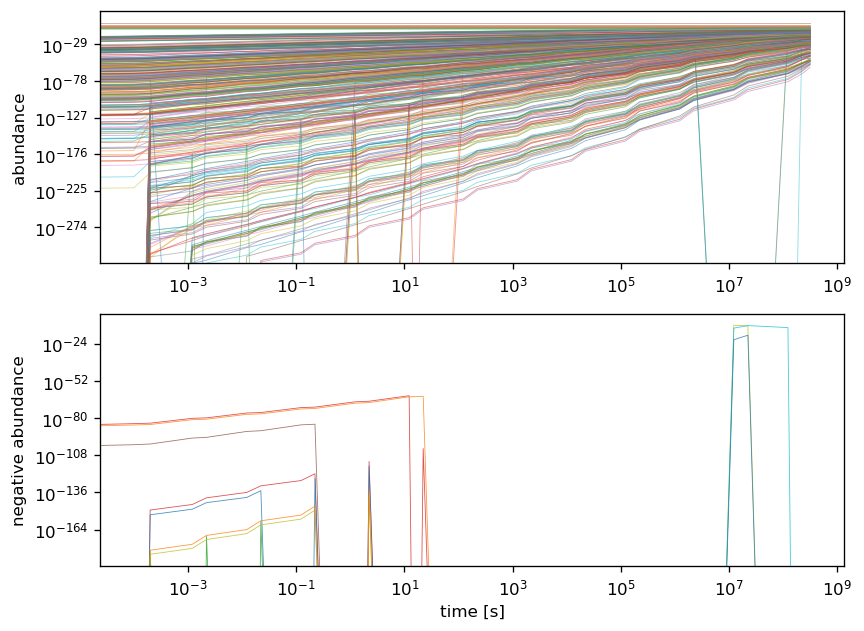

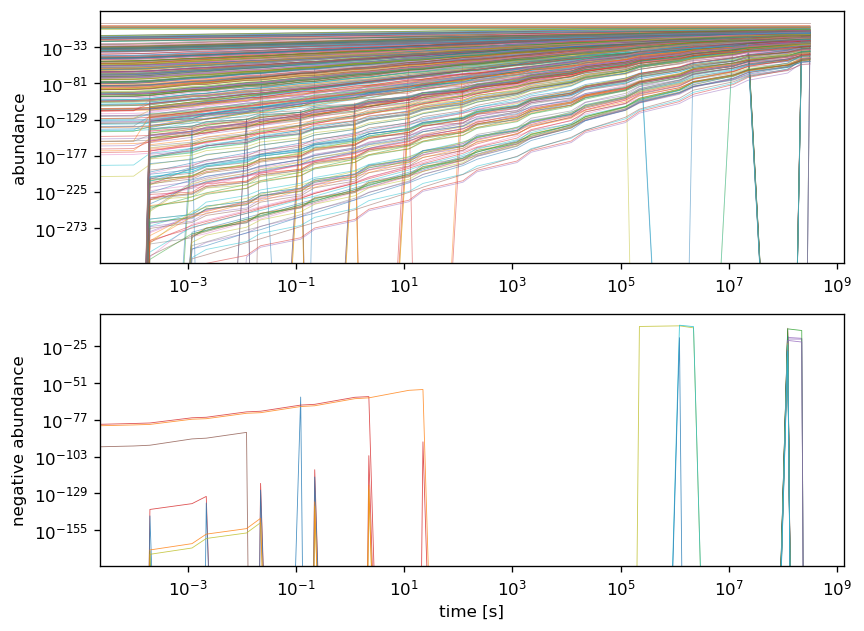

/tmp/ipykernel_112739/33606752.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


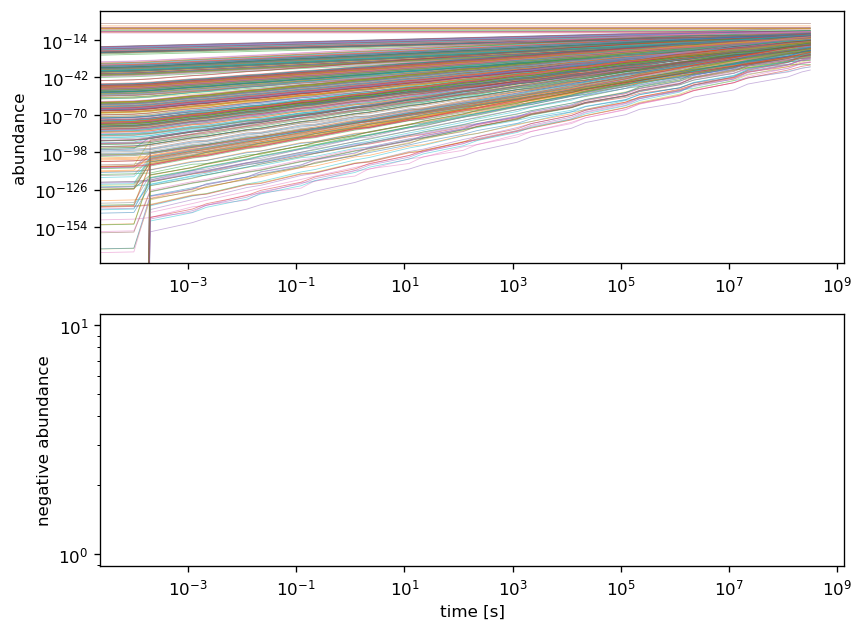

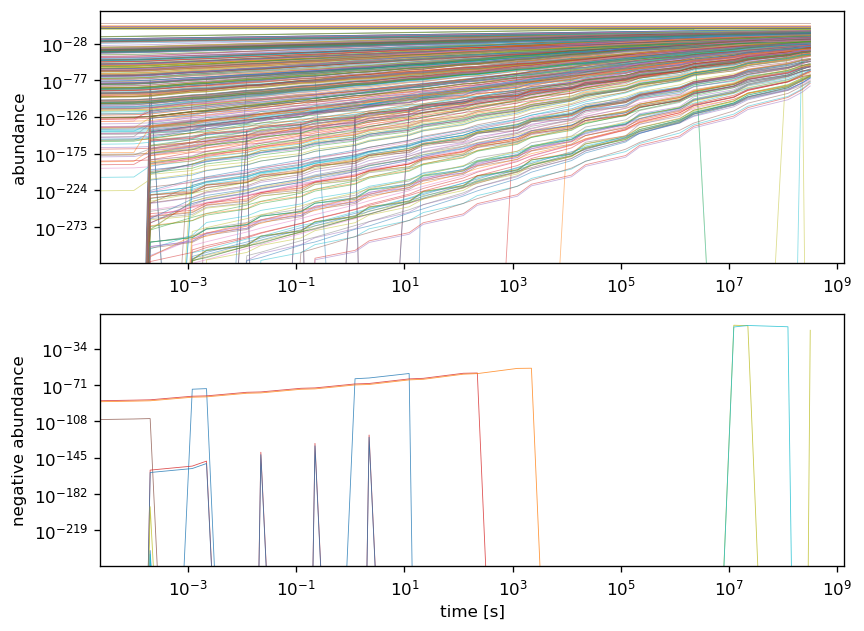

In [35]:
plot(ts1,ys1)
plot(ts2,ys2)
plot(ts3,ys3)
plot(ts4,ys4)
plt.show()

In [180]:
y = ys_O[0]

idx_neg, specs_neg = search_negs(y)
print('Negative values overal:')
print('#:',len(idx_neg))
print(idx_neg)
print(specs_neg)

print('')

el = 1
for el in range(y.shape[1]-1):
    idx_neg, specs_neg = search_negs(y, elwise = True, el=el)
    length = len(idx_neg)
    if el == 1:
        print('Negative values on first position:')
        print('#:',length)
        for i in range(length):
            print(idx_neg[i], specs_neg[i])
    if length != 0:
        print('\nNegative values on position',el)
        print('#:',length)
        print(idx_neg)
        print(specs_neg)

## Where first negative element?


Negative values overal:
#: 11
[38, 73, 75, 81, 129, 130, 353, 370, 392, 398, 401]
['F', 'C2H4', 'C2H5+', 'C2H5', 'Cl', 'Cl+', 'SiC3', 'C3P', 'SiC4', 'C4P', 'C4S']

Negative values on first position:
#: 3
73 C2H4
75 C2H5+
81 C2H5

Negative values on position 1
#: 3
[73, 75, 81]
['C2H4', 'C2H5+', 'C2H5']

Negative values on position 2
#: 8
[73, 75, 81, 353, 370, 392, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'SiC4', 'C4P', 'C4S']

Negative values on position 3
#: 7
[73, 75, 81, 353, 370, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'C4P', 'C4S']

Negative values on position 4
#: 8
[73, 75, 81, 353, 370, 392, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'SiC4', 'C4P', 'C4S']

Negative values on position 5
#: 7
[73, 75, 81, 353, 370, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'C4P', 'C4S']

Negative values on position 6
#: 8
[73, 75, 81, 353, 370, 392, 398, 401]
['C2H4', 'C2H5+', 'C2H5', 'SiC3', 'C3P', 'SiC4', 'C4P', 'C4S']

Negative values on position 7
#: 6
[

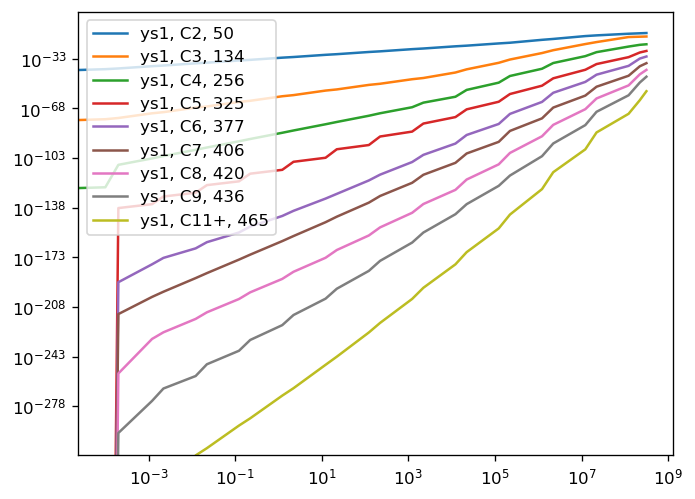

In [50]:
nbs = [50, 134, 256, 325, 377, 406, 420, 436, 465]
# nbs = []
# nbs = [ 441, 439, 465]

for nb in nbs:
    plt.loglog(ts1, (ys1[nb]), label = "ys1, "+specs[nb]+', '+str(nb))
    # plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    # plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    # plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

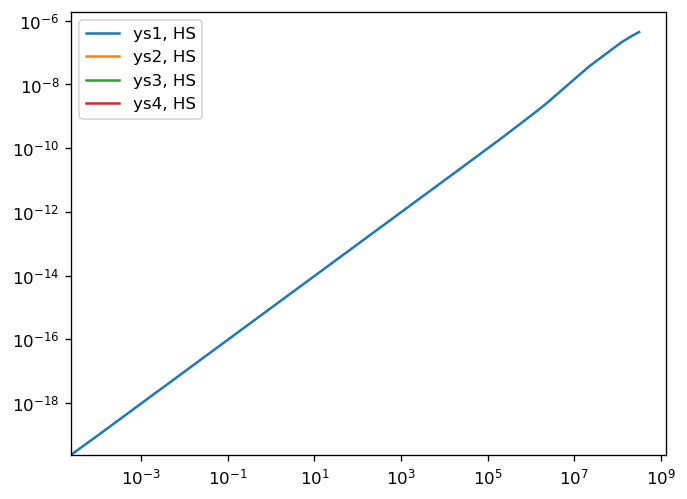

In [52]:
molecs = ['HS']

for molec in molecs:
    nb = specs_dict[molec]
    plt.loglog(ts1, ys1[nb], label = "ys1, "+specs[nb])
    plt.loglog(ts2, -ys2[nb], label = "ys2, "+specs[nb])
    plt.loglog(ts3, -ys3[nb], label = "ys3, "+specs[nb])
    plt.loglog(ts4, -ys4[nb], label = "ys4, "+specs[nb])
plt.legend(loc = 'upper left')
plt.show()

In [12]:
ions = list()
for spec in specs:
    if spec[-1] == '+' or spec[-1] == '-':
        ions.append(spec)


In [13]:
len(ions)

296